## Project Classification into Small, Medium, Large

In [1]:
library(data.table)
library(bnlearn)



Attaching package: 'bnlearn'


The following object is masked from 'package:stats':

    sigma




In [2]:
# showing for a smaple data, for actual analysis, full data was collected from multiple files and joined 
df = fread('/da0_data/play/trackhacks/woc-data-ahmed/PrInfo/PrAllInfo.csv', sep=';') # Read list of projects with info

# Preprocessing - remove NA
df$numStars = as.numeric(df$numStars) # warning is from this step
df[is.na(df)] = 0

# Subset & log transform for better results
df3 = df[,c(1,2,3)]
df3$NumAuthors = log(as.numeric(df3$NumAuthors) +1)
df3$numStars = log(df3$numStars +1)

str(df3)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


Classes 'data.table' and 'data.frame':	961734 obs. of  3 variables:
 $ projectID : chr  "0-admin_bitcoin" "00000SZ_node-rms" "000fan000_Onboard" "000panther_nativescript-plugin-firebase" ...
 $ numStars  : num  10.3 0 8.72 6 5.83 ...
 $ NumAuthors: num  9.56 1.1 4.51 5.25 4.25 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [3]:
dfm = bnlearn::discretize(df3[,c(2,3)], 'hartemink', breaks=3, ibreaks=10, idisc='interval') # discretization
summary(dfm)

           numStars             NumAuthors    
 [-0.0123,1.23]:921628   [0.682,1.81]:855795  
 (1.23,3.69]   : 27925   (1.81,2.94] : 81866  
 (3.69,12.3]   : 12181   (2.94,11.9] : 24073  

In [6]:
library(dplyr)
dff = cbind(df3, dfm %>% transmute(
    flag=ifelse(as.numeric(dfm$numStars) == 3| as.numeric(dfm$NumAuthors)==3,3, # If large by either variable -> large
                           ifelse(as.numeric(dfm$numStars)==2 | as.numeric(dfm$NumAuthors)==2,2,1)))) # If medium by either variable -> medium

dff$flag = factor(dff$flag)
summary(dff)
# flag = 1: Small, 2: Medium, 3: Large

  projectID            numStars         NumAuthors      flag      
 Length:961734      Min.   : 0.0000   Min.   : 0.6931   1:837848  
 Class :character   1st Qu.: 0.0000   1st Qu.: 0.6931   2: 95301  
 Mode  :character   Median : 0.0000   Median : 1.0986   3: 28585  
                    Mean   : 0.1605   Mean   : 1.2006             
                    3rd Qu.: 0.0000   3rd Qu.: 1.3863             
                    Max.   :12.2870   Max.   :11.9031             

## Plotting Code Reuse over time

In [7]:
# Read weekly reuse data
data = fread('/da4_data/play/trackhack/Analysis/CodeUsage/pivotWeekData.csv')


In [8]:
# Preprocess
data$TotalUsed = data$TotalUsed - data$`1`
data$TotalUnused = NULL

data$`1` = NULL
setcolorder(data, c('WeekNumber','TotalUsed', '3','4','5'))
colnames(data) = c('Weeks','Total re-used code blobs' , 'Re-used in Small OSS project',
                        'Re-used in Medium OSS project', 'Re-used in Large OSS project')
# data$`Re-used in Same project` = NULL
summary(data)


     Weeks        Total re-used code blobs Re-used in Small OSS project
 Min.   :  0.00   Min.   :   277.0         Min.   :  183.0             
 1st Qu.: 26.25   1st Qu.:   668.8         1st Qu.:  446.2             
 Median : 52.50   Median :   890.5         Median :  626.0             
 Mean   : 52.50   Mean   :  2538.8         Mean   : 1603.4             
 3rd Qu.: 78.75   3rd Qu.:  1340.2         3rd Qu.:  939.2             
 Max.   :105.00   Max.   :153973.0         Max.   :89225.0             
 Re-used in Medium OSS project Re-used in Large OSS project
 Min.   :   20.0               Min.   :    8.0             
 1st Qu.:   89.0               1st Qu.:   48.0             
 Median :  164.0               Median :  100.5             
 Mean   :  705.9               Mean   :  229.4             
 3rd Qu.:  269.5               3rd Qu.:  148.5             
 Max.   :52311.0               Max.   :12437.0             

In [9]:
# load additional libraries
library(ggplot2)
library(reshape2)
library(viridis)
library(hrbrthemes)


Attaching package: 'reshape2'


The following objects are masked from 'package:data.table':

    dcast, melt


Loading required package: viridisLite



In [11]:
# Get data for plotting
data2 = data
data2$`Total re-used code blobs` = NULL
dplot2 = melt(data2[-1,], id.vars=1)

dplot2 <- dplot2  %>%
  mutate(percentage = value*100 / 581579) # no. of blobs: 581579
summary(dplot2)

     Weeks                              variable       value       
 Min.   :  1   Re-used in Small OSS project :105   Min.   :   8.0  
 1st Qu.: 27   Re-used in Medium OSS project:105   1st Qu.:  95.0  
 Median : 53   Re-used in Large OSS project :105   Median : 190.0  
 Mean   : 53                                       Mean   : 365.5  
 3rd Qu.: 79                                       3rd Qu.: 490.5  
 Max.   :105                                       Max.   :3695.0  
   percentage      
 Min.   :0.001376  
 1st Qu.:0.016335  
 Median :0.032670  
 Mean   :0.062848  
 3rd Qu.:0.084339  
 Max.   :0.635339  

Loading required package: RColorBrewer

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



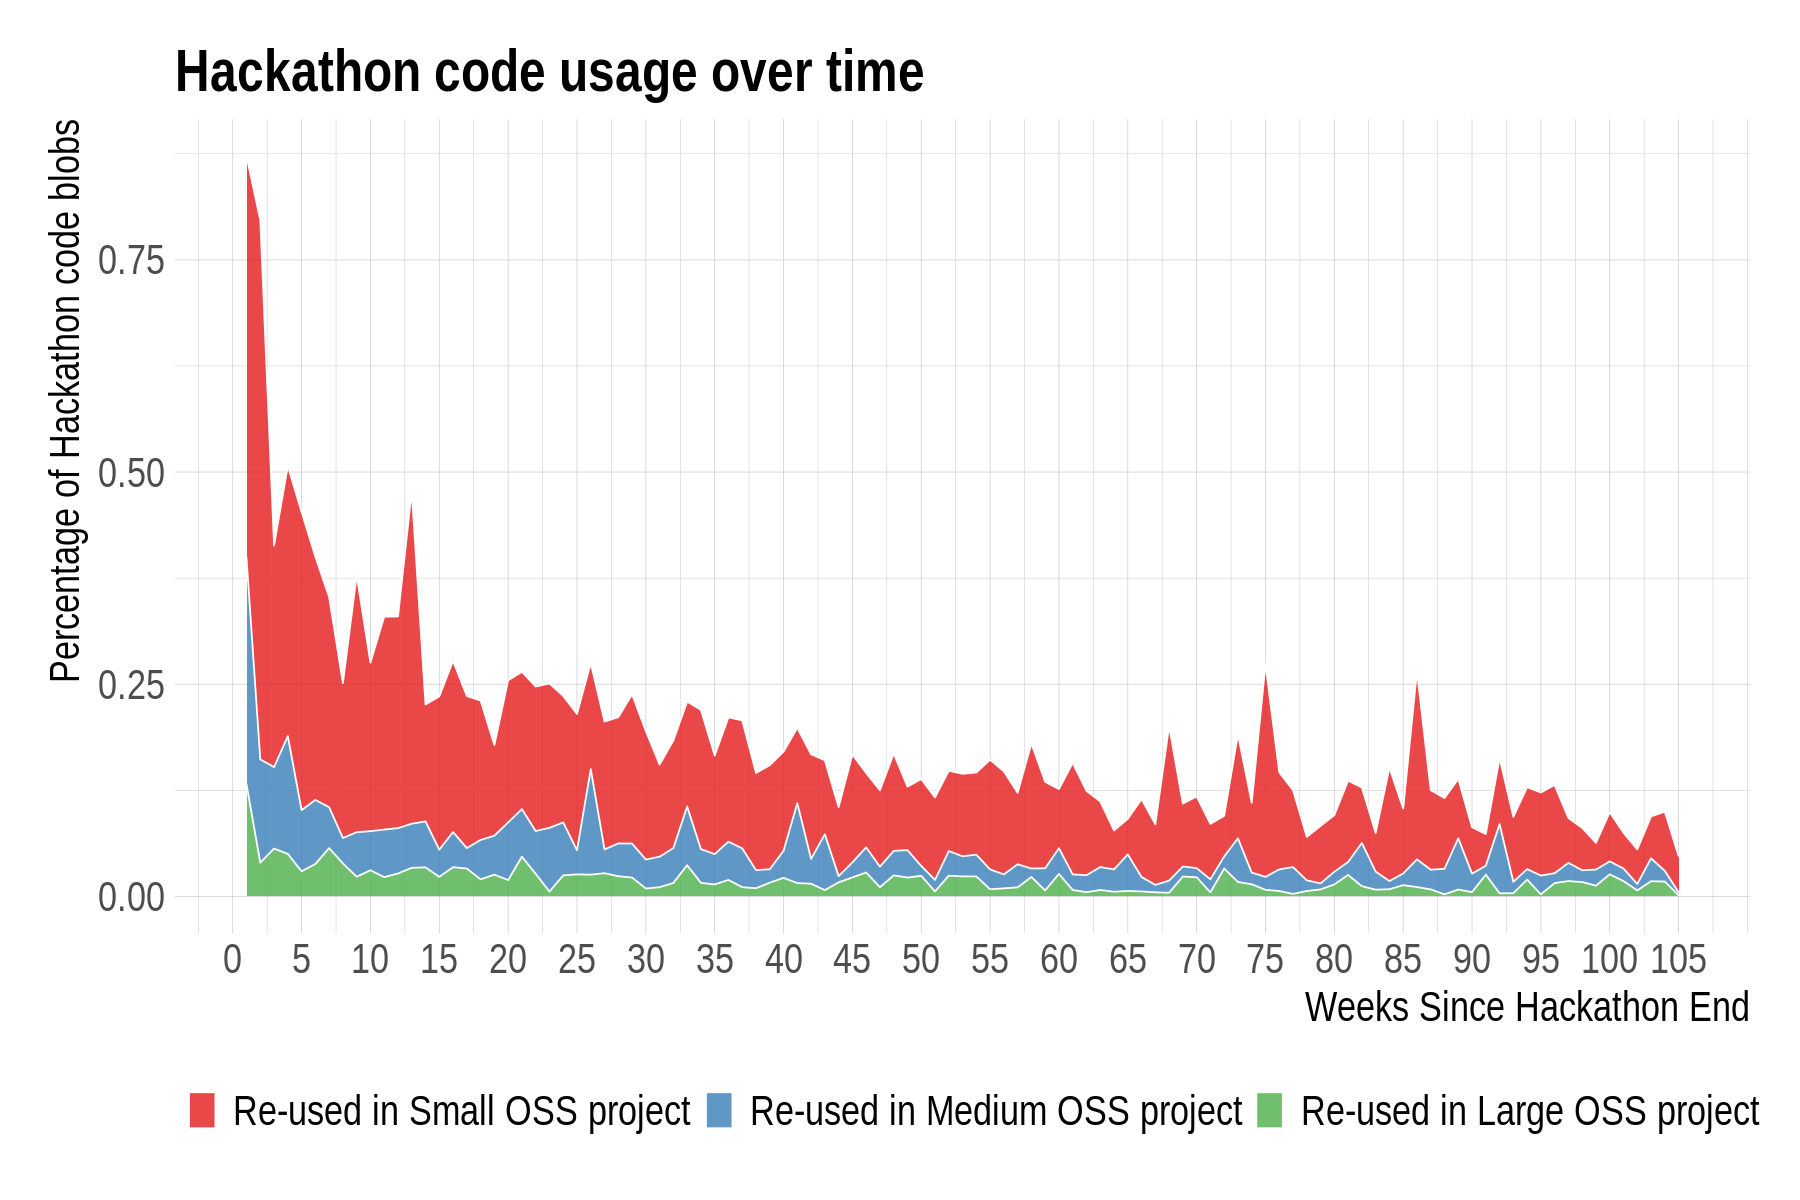

In [12]:
options(repr.plot.width = 15, repr.plot.height = 10) # bigger plot area
require(RColorBrewer)

ggplot(dplot2, aes(x=Weeks, y=percentage, fill=variable))+
     geom_area(size=0.5, alpha=0.8, color='white')+
     scale_fill_viridis(discrete = TRUE)+
     theme_ipsum(base_size = 25,   axis_title_size = 25, plot_title_size = 35)+
     ggtitle("Hackathon code usage over time")+
     xlab("Weeks Since Hackathon End")+ylab("Percentage of Hackathon code blobs")+
     scale_x_continuous(breaks = round(seq(0, 105, by = 5),1))+
     theme(text = element_text(size=20), legend.title=element_blank(), legend.position="bottom",
           axis.text.x = element_text(angle=0), legend.text=element_text(size=25), 
           axis.title=element_text(size=20,face="bold"))+
     scale_fill_brewer(palette="Set1")



## Generating plot for RQ1 result visualization

In [14]:
# Read and preprocess data
tdf = fread('/da4_data/play/trackhack/Analysis/CodeGeneration/RQ1Pivot.csv')

v = t(matrix(c("Total-AuthorType",as.numeric(colSums(tdf[,c(2:4)])))))
colnames(v) = colnames(tdf)
tdf = rbind(tdf,v ) %>% mutate_each_(as.numeric, c(2,3,4))

v = data.frame('Total TimingType'= rowSums(tdf %>% select(c(2,3,4))))
tdf = cbind(tdf,v)
colnames(tdf) = c('TimingFlag', 'Co-Contributor', 'Other Author', 'Project Member', 'Total-TimingType')

tdf


TimingFlag,Co-Contributor,Other Author,Project Member,Total-TimingType
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
After,0.08,0.29,4.93,5.30
Before,0.80,69.09,15.67,85.56
During,0.11,0.16,8.87,9.14
Total-AuthorType,0.99,69.54,29.47,100.00


In [15]:
# preparing data for plot
pdf = tdf
pdf$TimingFlag = factor(pdf$TimingFlag, levels=c('Total-AuthorType','After','During','Before'))
pdf = pdf %>% arrange(TimingFlag)
# pdf$AuthorFlag = colnames(pdf)[c(2:5)]
pdf = melt(pdf, id.vars=c(1))
# pdf$value = paste0(pdf$value, '%')
pdf

TimingFlag,variable,value
<fct>,<fct>,<dbl>
Total-AuthorType,Co-Contributor,0.99
After,Co-Contributor,0.08
During,Co-Contributor,0.11
Before,Co-Contributor,0.80
Total-AuthorType,Other Author,69.54
After,Other Author,0.29
During,Other Author,0.16
Before,Other Author,69.09
Total-AuthorType,Project Member,29.47


Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


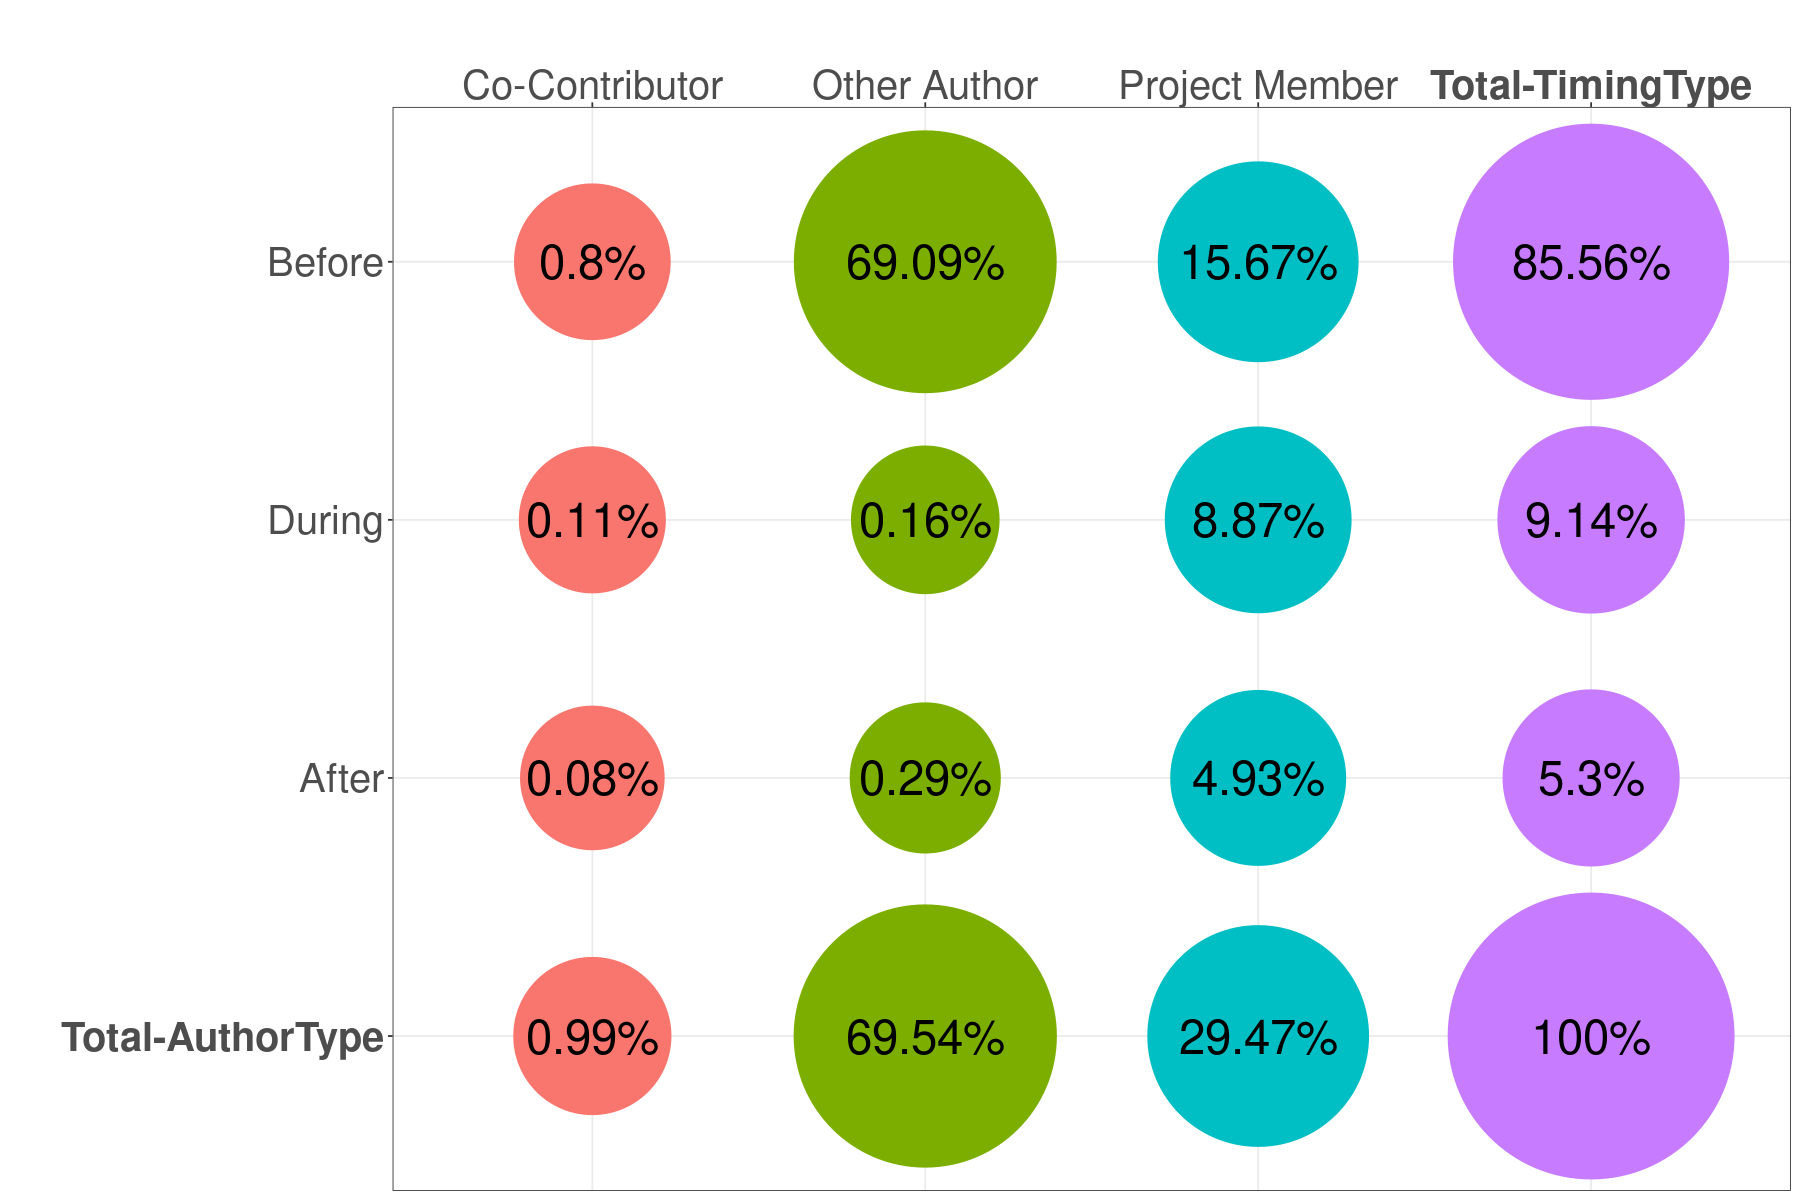

In [16]:
library(ggplot2)                           
ggplot(pdf, aes( variable, TimingFlag)) + 
geom_point(aes(size = value, color = variable)) + 
theme_bw() + xlab("") + ylab("")+scale_size_continuous(range=c(40,80)) + scale_x_discrete(position = "top") +
geom_text(aes(label = paste0(value,'%')), size=10) + theme(legend.position="none", text = element_text(size=30))+
theme(axis.text.x=element_text(face=c('plain','plain','plain','bold')), 
      axis.text.y=element_text(face=c('bold','plain','plain','plain')) )